# HOG Feature Extractor

# The most important HOG parameters are:
<ol>
<li>
<b>Pixels Per Cells:</b> Usually set as 4 or multiples of 4
</li>
<li>
<b>Cells per Block::</b> Usually set to {1,2,3}
</li>
</ol>

-Both parameters must be divisable by the sliding window size.

# The HOG Algorithm

As its name suggests, the HOG algorithm, is based on creating histograms from the orientation of image gradients. The HOG algorithm is implemented in a series of steps:

1. Given the image of particular object, set a detection window (region of interest) that covers the entire object in the image (see Fig. 3).

2. Calculate the magnitude and direction of the gradient for each individual pixel in the detection window.

3. Divide the detection window into connected *cells* of pixels, with all cells being of the same size (see Fig. 3). The size of the cells is a free parameter and it is usually chosen so as to match the scale of the features that want to be detected. For example, in a 64 x 128 pixel detection window, square cells 6 to 8 pixels wide are suitable for detecting human limbs.

4. Create a Histogram for each cell, by first grouping the gradient directions of all pixels in each cell into a particular number of orientation (angular) bins; and then adding up the gradient magnitudes of the gradients in each angular bin (see Fig. 3). The number of bins in the histogram is a free parameter and it is usually set to 9 angular bins.

5. Group adjacent cells into *blocks* (see Fig. 3). The number of cells in each block is a free parameter and all blocks must be of the same size. The distance between each block (known as the stride) is a free parameter but it is usually set to half the block size, in which case you will get overlapping blocks (*see video below*).  The HOG algorithm has been shown empirically to work better with overlapping blocks.

6. Use the cells contained within each block to normalize the cell histograms in that block (see Fig. 3). If you have overlapping blocks this means that most cells will be normalized with respect to different blocks (*see video below*). Therefore, the same cell may have several different normalizations.

7. Collect all the normalized histograms from all the blocks into a single feature vector called the HOG descriptor.

8. Use the resulting HOG descriptors from many images of the same type of object to train a machine learning algorithm, such as an SVM, to detect those type of objects in images. For example, you could use the HOG descriptors from many images of pedestrians to train an SVM to detect pedestrians in images. The training is done with both positive a negative examples of the object you want detect in the image.

9. Once the SVM has been trained, a sliding window approach is used to try to detect and locate objects in images.  Detecting an object in the image entails finding the part of the image that looks similar to the HOG pattern learned by the SVM.

<br>
<figure>
  <img src = "./images/hog.JPG" width = "100%" style = "border: thin silver solid; padding: 1px">
      <figcaption style = "text-align:left; font-style:italic">Fig. 3. - HOG Diagram.</figcaption>
</figure> 
<br>


# Hog Calculation Process Include:

<ol>
<li>Normalizing the image prior to description.
<li>Computing gradients in both the x and y directions.
<li>Obtaining weighted votes in spatial and orientation cells.
<li>Contrast normalizing overlapping spatial cells.
<li>Collecting all Histograms of Oriented gradients to form the final feature vector.
</ol>

In [76]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import imutils
from skimage import feature

In [77]:
def showimg(img,useOpenCV = False):
    if useOpenCV:
        cv2.imshow("Image",img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        
        plt.show()

In [78]:
def ExtractLogo(img):
    img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    canny = imutils.auto_canny(img_grey)
    cnts = cv2.findContours(canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnt = max(cnts, key=cv2.contourArea)
    (x,y,w,h) = cv2.boundingRect(cnt)
    cropped = img[y:y+h,x:x+w]
    showimg(cropped)
    return cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)

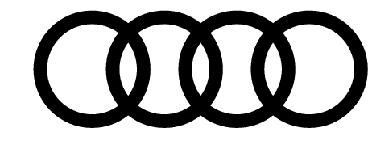

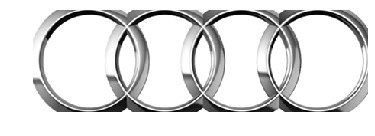

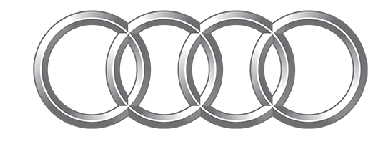

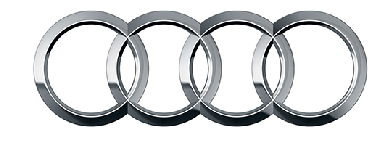

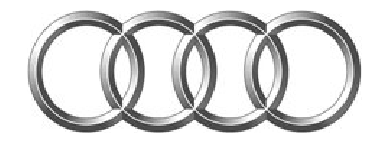

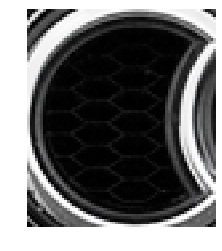

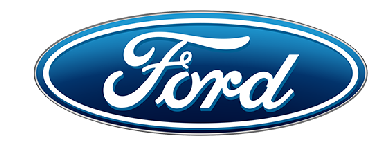

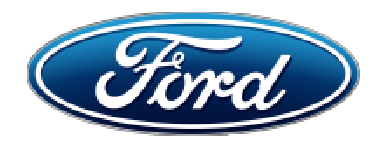

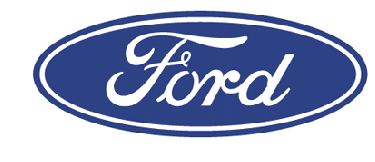

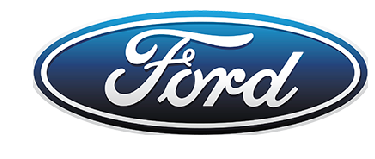

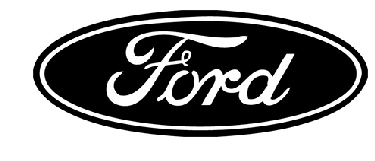

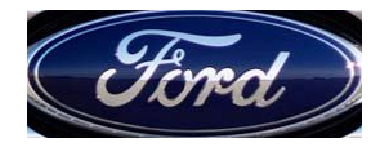

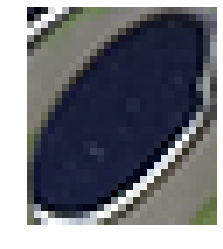

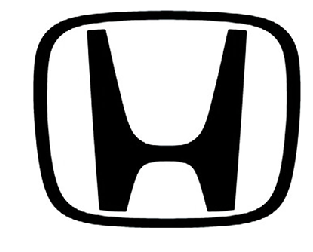

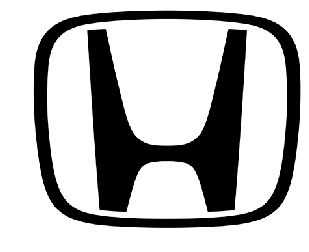

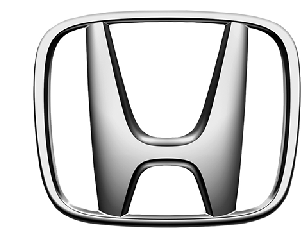

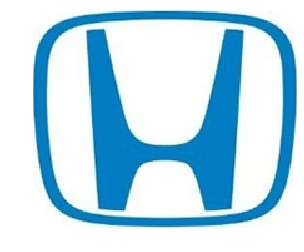

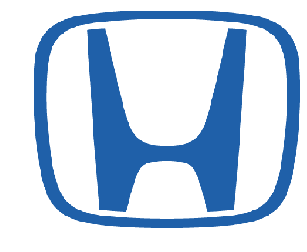

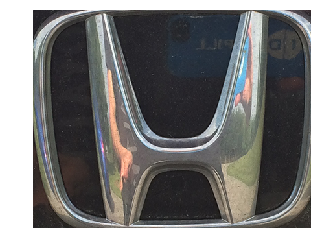

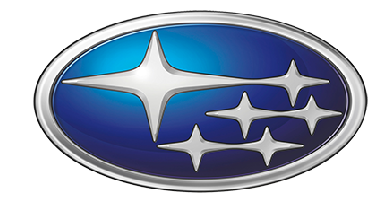

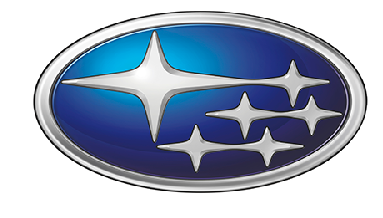

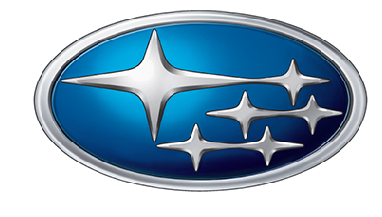

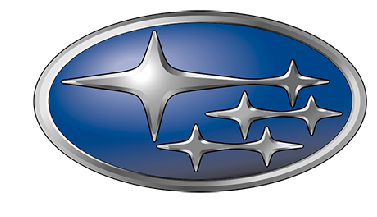

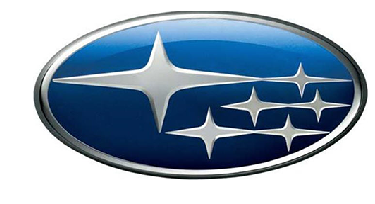

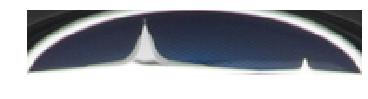

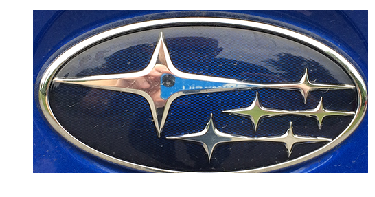

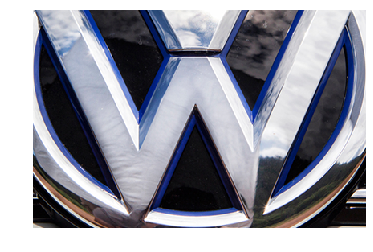

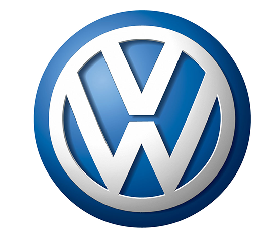

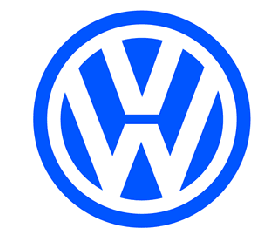

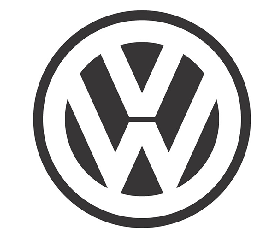

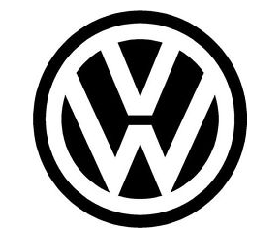

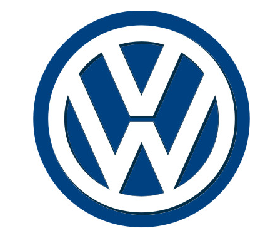

In [79]:
train_dir = r".\images\hog\car_logos\**"

features = []
labels = []

for img_path in [p for p in glob.glob(train_dir,recursive=True) if p.endswith(".png")]:
    img = cv2.imread(img_path)
    cropped = ExtractLogo(img)
    cropped = cv2.resize(cropped,(200,100))
    f = feature.hog(cropped,pixels_per_cell= (8,8),cells_per_block=(3,3),block_norm = "L1")
    features.append(f)
    labels.append(img_path.split("\\")[-2])

In [80]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.2,random_state = 14,stratify = labels)

In [81]:
from sklearn.svm import SVC
model = SVC(C=1.0 , kernel = "linear")
model.fit(X_train,y_train)
preds = model.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,preds)

1.0

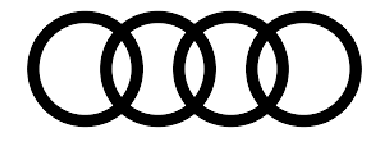

array(['audi'], dtype='<U10')

In [90]:
img = cv2.imread("./images/audi_logo.png")
cropped = ExtractLogo(img)
cropped = cv2.resize(cropped,(200,100))
f = feature.hog(cropped,pixels_per_cell= (8,8),cells_per_block=(3,3),block_norm = "L1")
pred = model.predict([f])
pred